In [11]:
import pandas as pd
from scipy.stats import zscore
import pandas as pd
from sklearn.preprocessing import StandardScaler

# load packages
import pandas as pd
from typing import Optional
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import os

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape
from datetime import date
import logging as log
from models.dataset import Dataset as Dataset

from models.utils import add_horizons, normalize
from models.gd import GradientDescent as GradientDescent
from models.utils import add_horizons, normalize,normalize_apply,normalize_train,ad_normalize,normalize_by_prev_day,print_cfm


In [12]:
# parameters
tickers="tza"
#tickers="slv,"
#tickers=("slv",)
iteration_no=200
model_shortname="all"
#0-> 10, 1->50,2->100
horizon_mapping = {
    0: 10,
    1: 50,
    2: 100
}
horizon_to_predict=2
look_back_window=100
batch_size=64
alpha=0.01

In [13]:
model_checkpoint_loc=f"/results/iteration{iteration_no}"
log_loc=f"/home/nnagara1/DNNLOB2/results/iteration{iteration_no}"
os.makedirs(f".{model_checkpoint_loc}", exist_ok=True)
tickers = tuple(x.strip() for x in tickers.split(","))
print(f"Running model with params Ticker: {tickers} Horizon Idx:{horizon_to_predict} window:{look_back_window} training batch size:{batch_size} alpha {alpha} iteration {iteration_no}")

Running model with params Ticker: ('tza',) Horizon Idx:2 window:100 training batch size:64 alpha 0.01 iteration 200


In [14]:
# Configure basic logging to a file
log.basicConfig(
    filename=f"{log_loc}/transferlearning.log",  # Name of the log file
    level=log.INFO,             # Minimum logging level to capture (e.g., INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format of the log messages
    datefmt='%Y-%m-%d %H:%M:%S'      # Format for the timestamp
)

In [15]:
#data_path="/home/nnagarajan/github/DNNLOB-FA800/data/etf/jan2025/cleaned/"
data_path="data/"
prefix="_cleaned_jan2025"

In [16]:
for ticker in tickers:
    log.info(f"Processing {ticker}")
    print(f"Processing {ticker}")    
    dataset_test: Optional[Dataset] = None
    df = pd.read_csv(f"{data_path}{ticker}{prefix}.csv",engine="pyarrow",sep = ',')
    print(df.describe())
    df["Date-Time"] = pd.to_datetime(df["Date-Time"])
    df["Date-Time"] = df["Date-Time"].dt.tz_convert("America/New_York")
    df=add_horizons(df,(10, 50, 100),alpha)
    class_summary = df.groupby(f"Target_{horizon_mapping[horizon_to_predict]}").size().reset_index(name="Count")
    # Calculate relative percentage
    class_summary["Percent"] = (class_summary["Count"] / class_summary["Count"].sum()) * 100
    class_summary["Percent"] = class_summary["Percent"].round(2)
    print(class_summary)
    #df=ad_normalize(df,100)
    normalize(df)
    #normalize_by_prev_day(df)
    df["Date"] = pd.to_datetime(df["Date-Time"]).dt.date
    df.groupby(["Date"]).size()    
    df_test = df[(df["Date"] >= date(2025, 1, 30)) & (df["Date"] <= date(2025, 1, 31))]
    #df_train, scaler = normalize_train(df_train)
    #df_val = normalize_apply(df_val,scaler)
    #df_test = normalize_apply(df_test,scaler)
    target_cols = [f"Target_{i}" for i in [10, 50, 100]]
    price_cols = [f"L{i}-BidPrice" for i in range(1, 11)] + [f"L{i}-AskPrice" for i in range(1, 11)]
    size_cols  = [f"L{i}-BidSize"  for i in range(1, 11)] + [f"L{i}-AskSize"  for i in range(1, 11)]        
    df_test =  df_test[price_cols + size_cols +target_cols]
    if None in (dataset_test,):        
        dataset_test = Dataset(data=df_test.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
    else:        
        dataset_test1 = Dataset(data=df_test.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)        

        dataset_test.merge(dataset_test1)

Processing tza
          rel.spread     abs.spread      mid_price    L1-BidPrice  \
count  211291.000000  211291.000000  211291.000000  211291.000000   
mean        0.001170       0.014701      12.590193      12.582843   
std         0.000793       0.009989       0.750123       0.750001   
min         0.000700       0.010000      11.485000      11.460000   
25%         0.000800       0.010000      12.005000      12.000000   
50%         0.000853       0.010000      12.400000      12.390000   
75%         0.001587       0.020000      13.215000      13.210000   
max         0.032618       0.380000      14.285000      14.280000   

          L1-BidSize    L1-AskPrice     L1-AskSize    L2-BidPrice  \
count  211291.000000  211291.000000  211291.000000  211291.000000   
mean    25599.103724      12.597544   22519.383093      12.572822   
std     21748.112621       0.750278   19786.785981       0.750015   
min         1.000000      11.490000       1.000000      11.450000   
25%      8100.0000

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_test.x.shape, dataset_test.y.shape)

torch.Size([19530, 1, 100, 40]) torch.Size([19530])


accuracy_score: 0.36415770609319
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      4669
           1     0.3627    0.5017    0.4211      7277
           2     0.3660    0.4564    0.4062      7584

    accuracy                         0.3642     19530
   macro avg     0.2429    0.3194    0.2758     19530
weighted avg     0.2773    0.3642    0.3146     19530



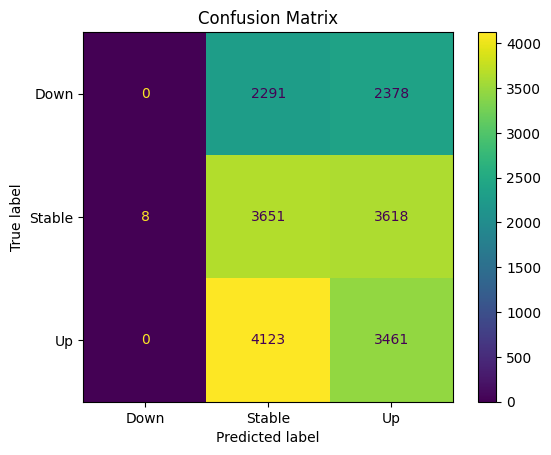

In [19]:
from models.deeplob import deeplob as deeplob
model = deeplob(device=device,y_len = dataset_test.num_classes)
model.to(device)
model_savepoint=f"{model_checkpoint_loc}/best_val_model_{model_shortname}_deeplob.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
from models.gd import GradientDescent as GradientDescent
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))
print_cfm(all_targets,all_predictions)

In [ ]:
from models.cnn1 import CNN1

model = CNN1(num_classes = dataset_test.num_classes)
model.to(device)
model_savepoint=f"{model_checkpoint_loc}/best_val_model_{model_shortname}_cnn1.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))
print_cfm(all_targets,all_predictions)

In [ ]:
from models.mlp import MLP

model = MLP()
model.to(device)
model_savepoint=f"{model_checkpoint_loc}/best_val_model_{model_shortname}_mlp.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))
print_cfm(all_targets,all_predictions)